In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

import glob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 150
np.random.seed(0)

In [2]:
def make_best_spec_high_sens_scorer(min_sensitivity: float = 0.98):

    def get_best_spec_high_sens(ytest, yscore):
        thrs = np.unique(yscore)
        best_spec = 0
        for thr in thrs:
            preds = yscore > thr
            tn, fp, fn, tp = metrics.confusion_matrix(ytest, preds).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)

            if sensitivity >= min_sensitivity:
                best_spec = max(specificity, best_spec)
        return best_spec

    return get_best_spec_high_sens


def get_best_args(val_df_group, model_name):
    return val_df_group.filter(regex=model_name, axis=0).round(2).sort_values(
        by=['spec90', 'aps'], kind='mergesort', ascending=False)['args'].iloc[0]

In [3]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET != 'csi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET != 'csi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        else:
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [4]:
DATASET = 'tbi'
seeds = sorted([
    int(path.split('_')[-1]) for path in glob.glob(f'results_2/{DATASET}/seed_*')])

In [5]:
for seed in seeds:
    dct = pkl.load(open(f'results_2/{DATASET}/seed_{seed}/best_models.pkl', 'rb'))
    print(seed, dct['pfigs_old'].max_rules, dct['pfigs_young'].max_rules, 
        dct['figs_old'].max_rules, dct['figs_young'].max_rules, dct['figs_all'].max_rules)

0 12 8 12 8 8
1 16 8 12 8 8
2 8 12 8 8 8
3 8 12 8 8 8
4 8 16 8 8 8
5 12 8 8 8 8
6 12 8 8 8 8
7 16 12 12 8 8
8 16 8 16 8 8
9 8 12 8 8 8


In [6]:
SPLIT_SEED = 0
pmodel_df = pd.read_csv(f'results_2/{DATASET}/seed_{SPLIT_SEED}/pmodel_val.csv').set_index('Unnamed: 0')
PMODEL = get_best_args(pmodel_df, f'^PFIGS')

### data setup

In [7]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [8]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df.drop(columns=['Age<2_no', 'Age<2_yes'])
feature_names = X_df_clean.columns

X_young, X_old = X_df_clean[~is_group_1], X_df_clean[is_group_1]
y_young, y_old = y[~is_group_1], y[is_group_1]

X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val = (
    model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, test_size=0.25, random_state=SPLIT_SEED))

X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

## Visualizing final models

In [9]:
best_models = pkl.load(open(f'results_2/{DATASET}/seed_{SPLIT_SEED}/best_models.pkl', 'rb'))

In [52]:
# def vizfigs(name):
#     best_models[name].feature_names_ = feature_names
#     print(best_models[name])

In [17]:
# plot_tree(best_models['cart_old'], feature_names=feature_names)

In [18]:
# X_df_clean.columns.tolist()

## tbi

In [19]:
# final_old = pkl.load(open(f'results/{DATASET}/all_model_old.pkl', 'rb'))
# final_young = pkl.load(open(f'results/{DATASET}/all_model_young.pkl', 'rb'))
# final_old.feature_names_ = feature_names
# final_young.feature_names_ = feature_names

In [68]:
best_models.keys()

dict_keys(['cart_all', 'figs_all', 'tao_all', 'cart_old', 'figs_old', 'tao_old', 'pecarn_old', 'cart_young', 'figs_young', 'tao_young', 'pecarn_young', 'pecarn_combine', 'figs_combine', 'tao_combine', 'cart_combine', 'pfigs_young', 'pfigs_old', 'pfigs_combine', 'pfigs_mix', 'pcart_young', 'pcart_old', 'pcart_combine', 'pcart_mix', 'figs_mix', 'cart_mix', 'tao_mix'])

In [40]:
X_df_clean.columns

Index(['Seiz', 'ActNorm', 'Vomit', 'Intubated', 'Paralyzed', 'Sedated', 'AMS',
       'AMSAgitated', 'AMSSleep', 'AMSSlow',
       ...
       'HemaLoc_Frontal', 'HemaLoc_Not applicable', 'HemaLoc_Occipital',
       'HemaLoc_Parietal/Temporal', 'HemaSize_Large', 'HemaSize_Medium',
       'HemaSize_Not applicable', 'HemaSize_Small', 'Gender_Female',
       'Gender_Male'],
      dtype='object', length=120)

In [41]:
# print(final_young.str_clinical(X_young.values, y_young))

------------
AMS <= 0.500 98/10721 (0.91%) TBI
	HemaLoc_Parietal/Temporal <= 0.500 48/9510 (0.5%) TBI
		High_impact_InjSev_High <= 0.500 26/8633 (0.3%) TBI
			SFxPalpDepress_1.0 <= 0.500 12/6902 (0.17%) TBI
				SeizLen_Not applicable <= 0.500 8/6891 (0.12%) TBI
					ΔRisk = 0.74 3/59 (5.08%) TBI
					SFxBas <= 0.500 5/6832 (0.07%) TBI
						ΔRisk = 0.05 4/6815 (0.06%) TBI
						ΔRisk = 0.87 1/17 (5.88%) TBI
				ΔRisk = 0.97 4/11 (36.36%) TBI
			HemaLoc_Occipital <= 0.500 14/1731 (0.81%) TBI
				AgeInMonth <= 6.500 9/1596 (0.56%) TBI
					ΔRisk = 0.60 8/519 (1.54%) TBI
					ΔRisk = 0.21 1/1077 (0.09%) TBI
				ΔRisk = 0.79 5/135 (3.7%) TBI
		ΔRisk = 0.72 22/877 (2.51%) TBI
	ΔRisk = 0.83 50/1211 (4.13%) TBI



In [42]:
# print(final_old.str_clinical(X_old.values, y_old))

------------
AMS <= 0.500 278/31707 (0.88%) TBI
	SFxBas <= 0.500 104/27422 (0.38%) TBI
		High_impact_InjSev_High <= 0.500 85/27255 (0.31%) TBI
			LOCSeparate_No <= 0.500 48/24028 (0.2%) TBI
				Amnesia_verb_0.0 <= 0.500 23/3543 (0.65%) TBI
					ΔRisk = 0.55 19/1881 (1.01%) TBI
					InjuryMech_BikeCol <= 0.500 4/1662 (0.24%) TBI
						ΔRisk = 0.07 1/1543 (0.06%) TBI
						ΔRisk = 0.74 3/119 (2.52%) TBI
				VomitStart_Not applicable <= 0.500 25/20485 (0.12%) TBI
					HA_verb_1.0 <= 0.500 13/1987 (0.65%) TBI
						ΔRisk = 0.10 0/946 (0.0%) TBI
						ΔRisk = 0.59 13/1041 (1.25%) TBI
					SFxPalpDepress_1.0 <= 0.500 12/18498 (0.06%) TBI
						OSIFlank <= 0.500 11/18477 (0.06%) TBI
							HASeverity_Severe <= 0.500 10/18232 (0.05%) TBI
								NeuroDCranial <= 0.500 8/18012 (0.04%) TBI
									ΔRisk = 0.05 7/17984 (0.04%) TBI
									ΔRisk = 0.80 1/28 (3.57%) TBI
								ΔRisk = 0.51 2/220 (0.91%) TBI
							ΔRisk = 0.52 1/245 (0.41%) TBI
						ΔRisk = 0.94 1/21 (4.76%) TBI
			ΔRisk = 0.58

### permutation importance

In [10]:
def get_all_features_used(figs):
    all_features = []
    def get_all_features_inner(tree):
        if tree.left is not None or tree.right is not None:
            all_features.append(tree.feature)
        if tree.left is not None:
            get_all_features_inner(tree.left)
        if tree.right is not None:
            get_all_features_inner(tree.right)
    for tree in figs.trees_:
        get_all_features_inner(tree)
    return np.sort(np.unique(all_features))

used_features = {}
for model in ['figs_all', 'pfigs_young', 'pfigs_old', 'figs_young', 'figs_old']:
    best_models[model].classes_ = np.unique(y_test_young)
    used_features[model] = get_all_features_used(best_models[model])

In [13]:
get_all_features_used(best_models['figs_all'])

array([  6,  13,  37,  57,  89, 101, 110, 117])

In [145]:
imps = {}
custom_score = metrics.make_scorer(make_best_spec_high_sens_scorer(0.8), greater_is_better=True, needs_proba=True)

In [146]:
imps['figs_all'] = permutation_importance(best_models['figs_all'], X_train_full, y_train_full, scoring='f1', n_jobs=10, n_repeats=10)
for model in ['pfigs_young']:
    imps[model] = permutation_importance(best_models[model], X_train_full_young, y_train_full_young, scoring='f1', n_jobs=10, n_repeats=10)
for model in ['pfigs_old']:
    imps[model] = permutation_importance(best_models[model], X_train_full_old, y_train_full_old, scoring='f1', n_jobs=10, n_repeats=10)
pkl.dump(imps, open(f'results_2/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'wb'))
imps = pkl.load(open(f'results_2/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'rb'))

In [63]:
def imp_plot(model):
    imp_means = pd.Series(imps[model].importances_mean, index=feature_names)[used_features[model]]
    imp_means_sort_ind = imp_means.argsort()[::-1]
    imp_means = imp_means[imp_means_sort_ind]
    imp_means.plot.bar(yerr=imps[model].importances_std[used_features[model]][imp_means_sort_ind])
    plt.ylabel("Mean F1 decrease")
    plt.xticks(rotation=45, ha="right")

Text(0.5, 1.0, 'Permutation importances, FIGS on all ages')

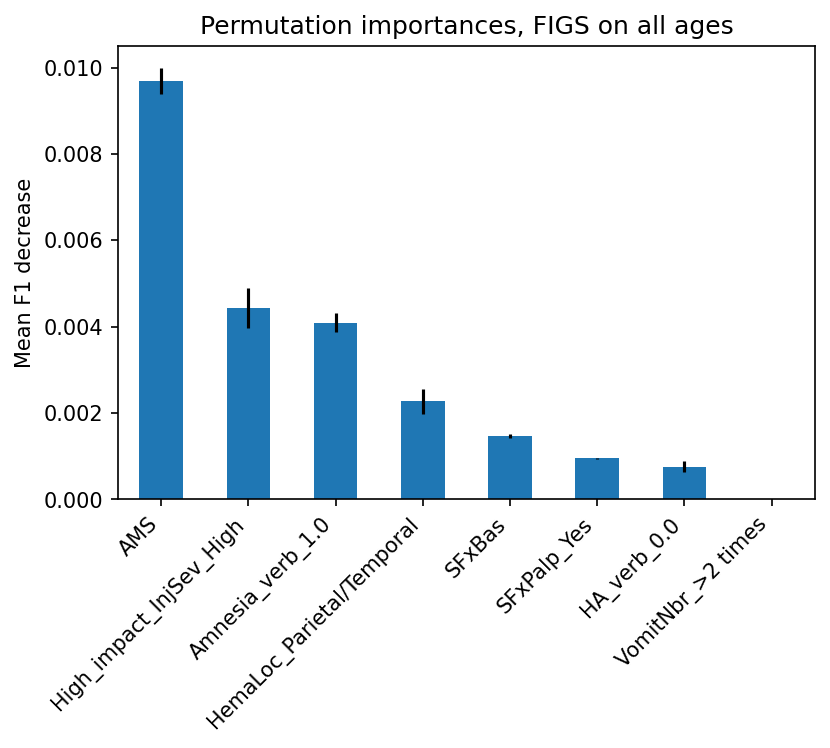

In [67]:
imp_plot('figs_all')
plt.title("Permutation importances, FIGS on all ages")

Text(0.5, 1.0, 'Permutation importances, TFIGS on <2')

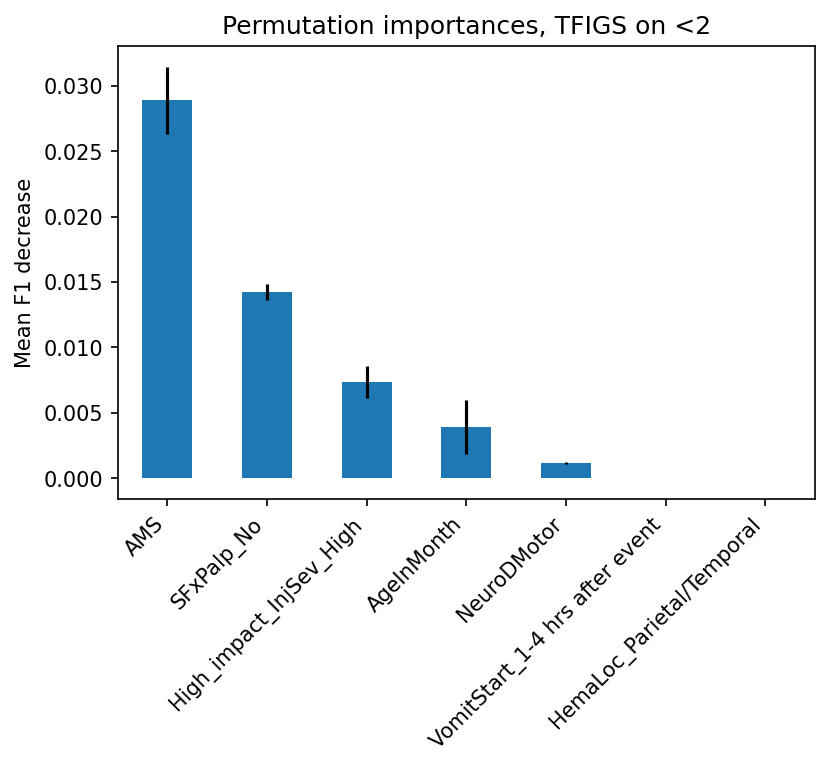

In [70]:
imp_plot('pfigs_young')
plt.title("Permutation importances, TFIGS on <2")

Text(0.5, 1.0, 'Permutation importances, TFIGS on >2')

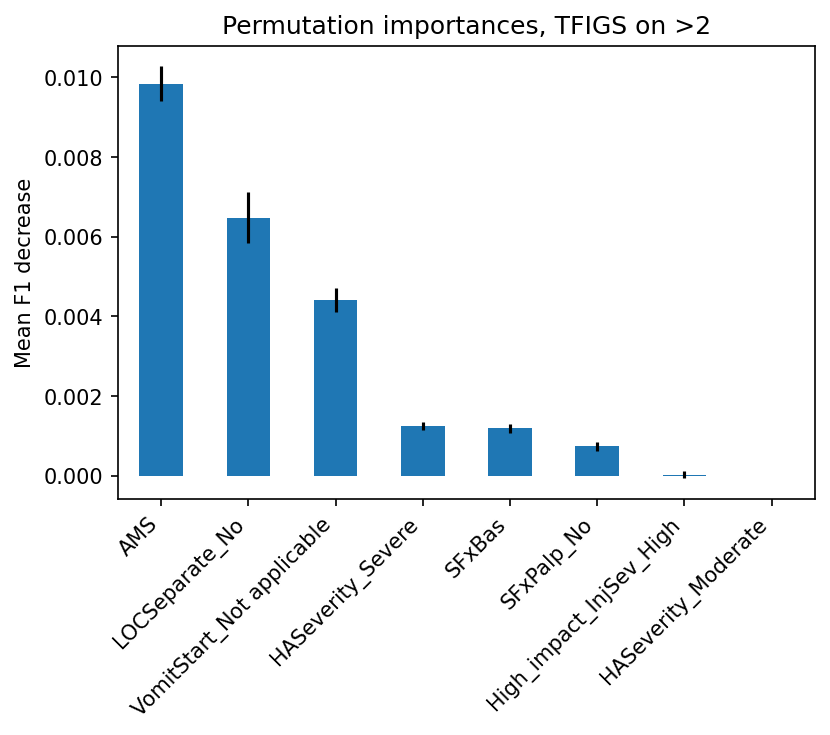

In [71]:
imp_plot('pfigs_old')
plt.title("Permutation importances, TFIGS on >2")

# Sensitivity-Specificity

In [10]:
def combine_LOC(df):
    df_ = df.copy()
    label_to_num = {'Suspected': 1, 'Yes': 1, 'No': 0, }
    df_['LOC'] = df_[['LOCSeparate_Yes', 'LOCSeparate_No', 'LOCSeparate_Suspected']].idxmax(1).str.split('_').apply(lambda x: x[1])
    df_['LOC'] = df_['LOC'].apply(lambda x: label_to_num[x])
    df_ = df_.drop(['LOCSeparate_Yes', 'LOCSeparate_No', 'LOCSeparate_Suspected'], axis=1)
    return df_

X_test_cart = combine_LOC(X_test)

In [11]:
def get_roc_data(models = ['cart_all', 'figs_all', 'pfigs_combine', 'figs_combine']):

    roc_data = {}

    for model in models:
        if 'cart' in model:
            X_ = X_test_cart
            y_ = y_test
        elif 'all' in model:
            X_ = X_test
            y_ = y_test
        elif 'young' in model:
            X_ = X_test_young
            y_ = y_test_young
        elif 'old' in model:
            X_ = X_test_old
            y_ = y_test_old
        y_scores = best_models[model].predict_proba(X_)[:, 0]
        # y_ = np.concatenate(y_list, axis=0)
        # y_scores = np.concatenate(y_scores, axis=0)
        roc_data[model] = metrics.roc_curve(y_, y_scores, pos_label=0) # fpr (1 - specificity), tpr (sensitivity), thresholds
    
    return roc_data

roc_data = get_roc_data()

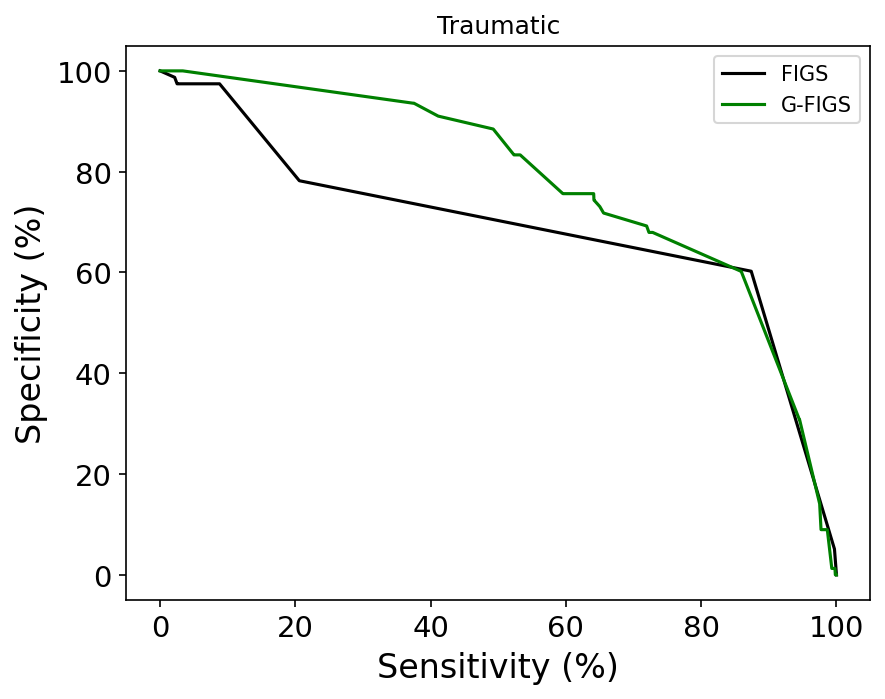

In [12]:
for model in ['figs_all', 'pfigs_combine']: # ['cart_all', 'figs_all', 'pfigs_combine']:
    colors = {
        'figs_all': 'k',
        'pfigs_combine': 'g',
        'cart_all': 'b',
    }
    labels = {
        'figs_all': 'FIGS',
        'pfigs_combine': 'G-FIGS',
        'cart_all': 'CART',
    }
    plt.plot(100 * roc_data[model][1], (1-roc_data[model][0]) * 100, color=colors[model], label=labels[model])
    plt.xlabel('Sensitivity (%)', size=16)
    plt.ylabel('Specificity (%)', size=16)
    plt.legend(loc='best')
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title('Traumatic')
plt.show()

[Text(0.7222222222222222, 0.9444444444444444, 'x[6] <= 0.5\ngini = 0.5\nsamples = 33942\nvalue = [33644, 32780]'),
 Text(0.5555555555555556, 0.8333333333333334, 'x[57] <= 0.5\ngini = 0.423\nsamples = 29524\nvalue = [29407, 12870]'),
 Text(0.3888888888888889, 0.7222222222222222, 'x[13] <= 0.5\ngini = 0.344\nsamples = 25328\nvalue = [25263, 7150]'),
 Text(0.3333333333333333, 0.6111111111111112, 'x[117] <= 0.5\ngini = 0.302\nsamples = 25194\nvalue = [25142, 5720]'),
 Text(0.16666666666666666, 0.5, 'x[101] <= 0.5\ngini = 0.209\nsamples = 22131\nvalue = [22104, 2970]'),
 Text(0.1111111111111111, 0.3888888888888889, 'gini = 0.457\nsamples = 427\nvalue = [420, 770]'),
 Text(0.2222222222222222, 0.3888888888888889, 'x[89] <= 0.5\ngini = 0.167\nsamples = 21704\nvalue = [21684, 2200]'),
 Text(0.16666666666666666, 0.2777777777777778, 'x[37] <= 0.5\ngini = 0.12\nsamples = 20798\nvalue = [20785, 1430]'),
 Text(0.1111111111111111, 0.16666666666666666, 'x[110] <= 0.5\ngini = 0.088\nsamples = 20582\nva

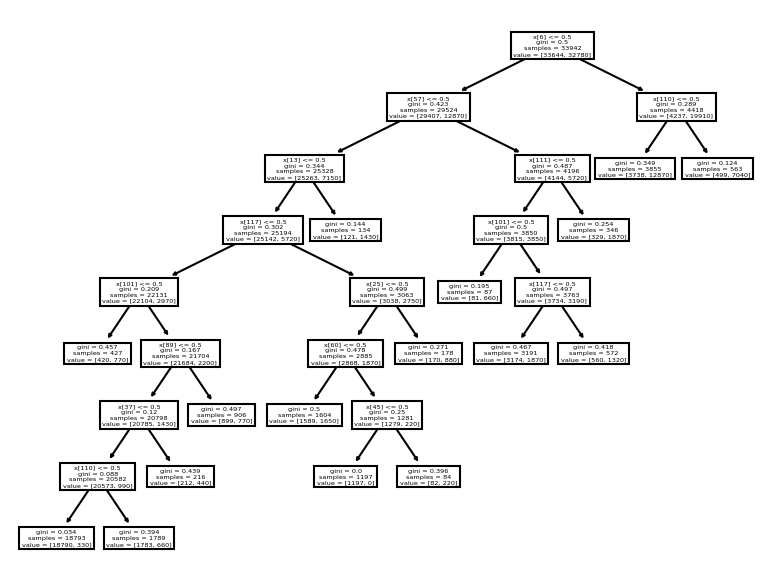

In [13]:
plot_tree(best_models['cart_all'])

In [14]:
val_df = pd.read_csv(f'results_2/{DATASET}/seed_{SPLIT_SEED}/val.csv').set_index('Unnamed: 0')
val_df

,spec90,spec92,spec94,spec96,spec98,aps,auc,acc,f1,args
Unnamed: 0,,,,,,,,,,
CART_<2_8,0.830225,0.830225,0.715447,0.715447,0.715447,0.043762,0.913214,0.831039,0.077720,"{'max_leaf_nodes': 8, 'random_state': 0}"
CART_>2_8,0.031294,0.031294,0.031294,0.031294,0.031294,0.026424,0.786907,0.719862,0.041823,"{'max_leaf_nodes': 8, 'random_state': 0}"
CART_all_8,0.585293,0.585293,0.000000,0.000000,0.000000,0.031924,0.828210,0.735093,0.046650,"{'max_leaf_nodes': 8, 'random_state': 0}"
CART_<2_12,0.828312,0.828312,0.637972,0.637972,0.637972,0.043337,0.907954,0.804461,0.067873,"{'max_leaf_nodes': 12, 'random_state': 0}"
CART_>2_12,0.062905,0.062905,0.062905,0.062905,0.000000,0.025648,0.768285,0.836495,0.050955,"{'max_leaf_nodes': 12, 'random_state': 0}"
CART_all_12,0.639819,0.639819,0.054526,0.054526,0.054526,0.033300,0.832027,0.710111,0.042802,"{'max_leaf_nodes': 12, 'random_state': 0}"
CART_<2_16,0.814443,0.814443,0.000000,0.000000,0.000000,0.041399,0.885536,0.790223,0.063559,"{'max_leaf_nodes': 16, 'random_state': 0}"
CART_>2_16,0.077920,0.077920,0.077920,0.000000,0.000000,0.025364,0.760897,0.832262,0.049734,"{'max_leaf_nodes': 16, 'random_state': 0}"
CART_all_16,0.087669,0.087669,0.087669,0.087669,0.000000,0.034517,0.827413,0.766910,0.050864,"{'max_leaf_nodes': 16, 'random_state': 0}"
